# MNIST 분류를 위한 LeNet-5 모델 학습

LeNet-5 : 2 convolutional layers, 3 fully conncected layers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 폴더 경로 저장

In [2]:
datasetPath = "./drive/MyDrive/dataset/"
parameterPath = "./drive/MyDrive/parameters"

### 패키지 선언

In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader

### 데이터셋 선언

In [4]:
# Training dataset 다운로드
mnist_train = dataset.MNIST(root = datasetPath,
                            train = True, # train 데이터셋이면 true
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
mnist_test = dataset.MNIST(root = datasetPath,
                           train = False, # train 데이터셋이 아닌(test 데이터셋이면) false
                           transform = transform.ToTensor(),
                           download = True)

60000
torch.Size([1, 28, 28])
5


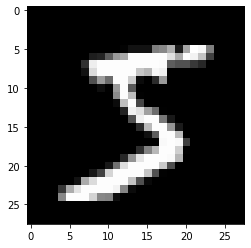

In [5]:
# MNIST 데이터셋 형상 확인
import matplotlib.pyplot as plt
print(len(mnist_train)) #train 데이터셋 개수 확인 : 6만개

first_data = mnist_train[0] 
print(first_data[0].shape)  # 첫번째 data의 형상 확인 - 데이터 이미지 (1x28x28pixels)
print(first_data[1])        # 첫번째 data의 정답 확인 - 데이터 값(숫자) (5)

plt.imshow(first_data[0][0,:,:], cmap = 'gray')
plt.show()

## CNN 모델 정의

**Conv2d : Convolution layer**

torch.nn.Conv2d(***in_channels***, ***out_channels***, ***kernel_size***, **stride=1**, **padding=0**, dilation=1,groups=1,bias=True,padding_mode='zeros',device=None,dtype=None)

**Linear : Fully connected layer**

torch.nn.Linear(***in_features***, ***out_features***, bias=True,device=None, dype=None)

**ReLU : Activation Function**

torch.nn.ReLU(inplace=False)

**MaxPool2d : Pooling layer**

torch.nn.MaxPool2d(**kernel_size**, **stride=None**, padding=0, dilation=1 return_indices=False,ceil_mode=False)

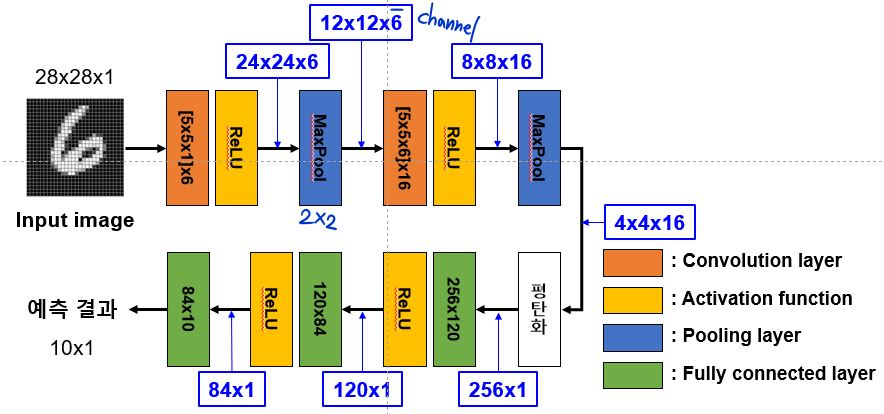

28x28x**1** -conv1[5x5x**1**]x**6**->  24x24x**6**

In [22]:
class LeNet5 (nn.Module):
  def __init__(self): # Parameter를 가지는 lalyer 정보
    super(LeNet5, self).__init__()  #자기 자신을 또 부름
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(in_features=256, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)
    self.relu = nn.ReLU()
    self.maxPool2d = nn.MaxPool2d(kernel_size=2, stride=2)  # ReLU, Pooling layer는 parameter를 안 가짐

  def forward(self, x):  # 모델의 동작 순서, 각 layer & function의 입출력 관계
    out = self.relu(self.conv1(x))
    out = self.maxPool2d(out)
    out = self.relu(self.conv2(out))
    out = self.maxPool2d(out)

    out = out.view(-1, 256) # feature map 평탄화
    out = self.relu(self.fc1(out))
    out = self.relu(self.fc2(out))
    out = self.fc3(out)
    return out

### Hyper-parameters 지정

In [23]:
batch_size = 100
learning_rate = 0.1
training_epoch = 15
loss_function = nn.CrossEntropyLoss()
network = LeNet5()
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)

data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

### Network Training

In [24]:
for epoch in range(training_epoch):
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:
      pred = network(img)

      loss = loss_function(pred, label) # 입력 이미지에 대해 forward pass
      optimizer.zero_grad() # gradient(기울기) 초기화 # 예측 값, 정답을 이용해 loss 계산
      loss.backward() #back propagation # 모든 weight에 대해 편미분 값 계산
      optimizer.step()  # 파라미터 업데이트

      avg_cost += loss / total_batch
      
  print('Epoch: %d Loss = %f' %(epoch + 1, avg_cost))

print('Learning finished')


Epoch: 1 Loss = 1.964078
Epoch: 2 Loss = 0.226312
Epoch: 3 Loss = 0.110752
Epoch: 4 Loss = 0.082247
Epoch: 5 Loss = 0.067492
Epoch: 6 Loss = 0.057410
Epoch: 7 Loss = 0.050776
Epoch: 8 Loss = 0.044025
Epoch: 9 Loss = 0.037675
Epoch: 10 Loss = 0.034357
Epoch: 11 Loss = 0.032200
Epoch: 12 Loss = 0.027891
Epoch: 13 Loss = 0.025013
Epoch: 14 Loss = 0.022619
Epoch: 15 Loss = 0.020626
Learning finished


weight parameter 저장

In [14]:
torch.save(network.state_dict(), parameterPath+"LeNet5_mnist.pth")

MNIST Test dataset 분류 성능 확인

In [15]:
with torch.no_grad(): # test에서는 기울기 계산 제외
  
  img_test = mnist_test.data.float().unsqueeze(1) # 새로운 차원(channel) 추가 
  # [Batch x Channel x Height x Width] eff10000 x 28 x 28 -> 10000 x 1 x 28 x 28
  label_test = mnist_test.targets

  prediction = network(img_test)  # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print("Accuracy:", accuracy.item())

Accuracy: 0.9882000088691711
